# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import pycountry
import retry
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
current_hour = datetime.datetime.utcnow().hour
are_today_results_partial = current_hour != 23

### Constants

In [3]:
from Modules.ExposureNotification import exposure_notification_io

spain_region_country_code = "ES"
germany_region_country_code = "DE"

default_backend_identifier = spain_region_country_code

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

### Parameters

In [4]:
environment_backend_identifier = os.environ.get("RADARCOVID_REPORT__BACKEND_IDENTIFIER")
if environment_backend_identifier:
    report_backend_identifier = environment_backend_identifier
else:
    report_backend_identifier = default_backend_identifier
report_backend_identifier

'ES'

In [5]:
environment_enable_multi_backend_download = \
    os.environ.get("RADARCOVID_REPORT__ENABLE_MULTI_BACKEND_DOWNLOAD")
if environment_enable_multi_backend_download:
    report_backend_identifiers = None
else:
    report_backend_identifiers = [report_backend_identifier]

report_backend_identifiers

In [6]:
environment_invalid_shared_diagnoses_dates = \
    os.environ.get("RADARCOVID_REPORT__INVALID_SHARED_DIAGNOSES_DATES")
if environment_invalid_shared_diagnoses_dates:
    invalid_shared_diagnoses_dates = environment_invalid_shared_diagnoses_dates.split(",")
else:
    invalid_shared_diagnoses_dates = []

invalid_shared_diagnoses_dates

['2020-10-30', '2020-12-02', '2020-12-05', '2020-12-19', '2020-12-20']

### COVID-19 Cases

In [7]:
report_backend_client = \
    exposure_notification_io.get_backend_client_with_identifier(
        backend_identifier=report_backend_identifier)

In [8]:
@retry.retry(tries=10, delay=10, backoff=1.1, jitter=(0, 10))
def download_cases_dataframe():
    return pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

confirmed_df_ = download_cases_dataframe()
confirmed_df_.iloc[0]

iso_code                                         AFG
continent                                       Asia
location                                 Afghanistan
date                                      2020-02-24
total_cases                                        1
new_cases                                          1
new_cases_smoothed                               NaN
total_deaths                                     NaN
new_deaths                                       NaN
new_deaths_smoothed                              NaN
total_cases_per_million                        0.026
new_cases_per_million                          0.026
new_cases_smoothed_per_million                   NaN
total_deaths_per_million                         NaN
new_deaths_per_million                           NaN
new_deaths_smoothed_per_million                  NaN
reproduction_rate                                NaN
icu_patients                                     NaN
icu_patients_per_million                      

In [9]:
confirmed_df = confirmed_df_.copy()
confirmed_df = confirmed_df[["date", "new_cases", "iso_code"]]
confirmed_df.rename(
    columns={
        "date": "sample_date",
        "iso_code": "country_code",
    },
    inplace=True)

def convert_iso_alpha_3_to_alpha_2(x):
    try:
        return pycountry.countries.get(alpha_3=x).alpha_2
    except Exception as e:
        logging.info(f"Error converting country ISO Alpha 3 code '{x}': {repr(e)}")
        return None

confirmed_df["country_code"] = confirmed_df.country_code.apply(convert_iso_alpha_3_to_alpha_2)
confirmed_df.dropna(inplace=True)
confirmed_df["sample_date"] = pd.to_datetime(confirmed_df.sample_date, dayfirst=True)
confirmed_df["sample_date"] = confirmed_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases,country_code
13662,2021-03-19,0.0,CF
43736,2021-03-19,28.0,MR
13209,2021-03-19,76.0,CV
53862,2021-03-19,2006.0,PY
76004,2021-03-19,41.0,ZW


In [10]:
confirmed_days = pd.date_range(
    start=confirmed_df.iloc[0].sample_date,
    end=extraction_datetime)
confirmed_days_df = pd.DataFrame(data=confirmed_days, columns=["sample_date"])
confirmed_days_df["sample_date_string"] = \
    confirmed_days_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_days_df.tail()

,sample_date,sample_date_string
418,2021-03-16,2021-03-16
419,2021-03-17,2021-03-17
420,2021-03-18,2021-03-18
421,2021-03-19,2021-03-19
422,2021-03-20,2021-03-20


In [11]:
def sort_source_regions_for_display(source_regions: list) -> list:
    if report_backend_identifier in source_regions:
        source_regions = [report_backend_identifier] + \
            list(sorted(set(source_regions).difference([report_backend_identifier])))
    else:
        source_regions = list(sorted(source_regions))
    return source_regions

In [12]:
report_source_regions = report_backend_client.source_regions_for_date(
    date=extraction_datetime.date())
report_source_regions = sort_source_regions_for_display(
    source_regions=report_source_regions)
report_source_regions

['ES']

In [13]:
def get_cases_dataframe(source_regions_for_date_function, columns_suffix=None):
    source_regions_at_date_df = confirmed_days_df.copy()
    source_regions_at_date_df["source_regions_at_date"] = \
        source_regions_at_date_df.sample_date.apply(
            lambda x: source_regions_for_date_function(date=x))
    source_regions_at_date_df.sort_values("sample_date", inplace=True)
    source_regions_at_date_df["_source_regions_group"] = source_regions_at_date_df. \
        source_regions_at_date.apply(lambda x: ",".join(sort_source_regions_for_display(x)))
    source_regions_at_date_df.tail()

    #%%

    source_regions_for_summary_df_ = \
        source_regions_at_date_df[["sample_date", "_source_regions_group"]].copy()
    source_regions_for_summary_df_.rename(columns={"_source_regions_group": "source_regions"}, inplace=True)
    source_regions_for_summary_df_.tail()

    #%%

    confirmed_output_columns = ["sample_date", "new_cases", "covid_cases"]
    confirmed_output_df = pd.DataFrame(columns=confirmed_output_columns)

    for source_regions_group, source_regions_group_series in \
            source_regions_at_date_df.groupby("_source_regions_group"):
        source_regions_set = set(source_regions_group.split(","))
        confirmed_source_regions_set_df = \
            confirmed_df[confirmed_df.country_code.isin(source_regions_set)].copy()
        confirmed_source_regions_group_df = \
            confirmed_source_regions_set_df.groupby("sample_date").new_cases.sum() \
                .reset_index().sort_values("sample_date")
        confirmed_source_regions_group_df = \
            confirmed_source_regions_group_df.merge(
                confirmed_days_df[["sample_date_string"]].rename(
                    columns={"sample_date_string": "sample_date"}),
                how="right")
        confirmed_source_regions_group_df["new_cases"] = \
            confirmed_source_regions_group_df["new_cases"].clip(lower=0)
        confirmed_source_regions_group_df["covid_cases"] = \
            confirmed_source_regions_group_df.new_cases.rolling(7, min_periods=0).mean().round()
        confirmed_source_regions_group_df = \
            confirmed_source_regions_group_df[confirmed_output_columns]
        confirmed_source_regions_group_df = confirmed_source_regions_group_df.replace(0, np.nan)
        confirmed_source_regions_group_df.fillna(method="ffill", inplace=True)
        confirmed_source_regions_group_df = \
            confirmed_source_regions_group_df[
                confirmed_source_regions_group_df.sample_date.isin(
                    source_regions_group_series.sample_date_string)]
        confirmed_output_df = confirmed_output_df.append(confirmed_source_regions_group_df)

    result_df = confirmed_output_df.copy()
    result_df.tail()

    #%%

    result_df.rename(columns={"sample_date": "sample_date_string"}, inplace=True)
    result_df = confirmed_days_df[["sample_date_string"]].merge(result_df, how="left")
    result_df.sort_values("sample_date_string", inplace=True)
    result_df.fillna(method="ffill", inplace=True)
    result_df.tail()

    #%%

    result_df[["new_cases", "covid_cases"]].plot()

    if columns_suffix:
        result_df.rename(
            columns={
                "new_cases": "new_cases_" + columns_suffix,
                "covid_cases": "covid_cases_" + columns_suffix},
            inplace=True)
    return result_df, source_regions_for_summary_df_

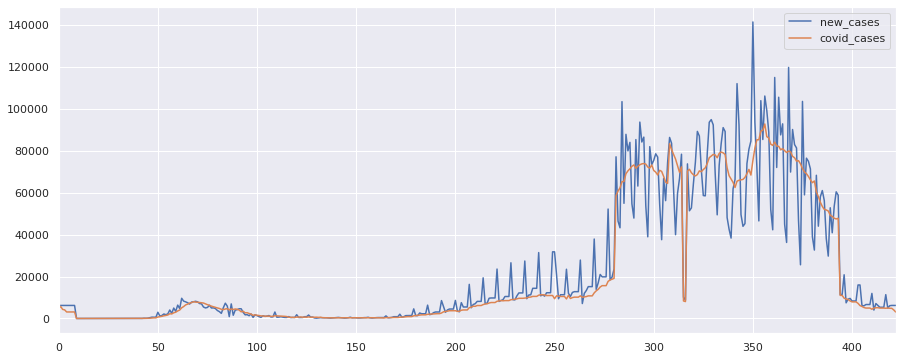

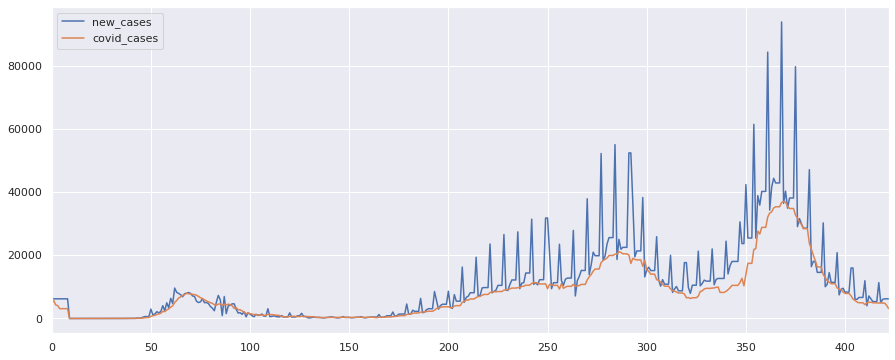

In [14]:
confirmed_eu_df, source_regions_for_summary_df = get_cases_dataframe(
    report_backend_client.source_regions_for_date)
confirmed_es_df, _ = get_cases_dataframe(
    lambda date: [spain_region_country_code],
    columns_suffix=spain_region_country_code.lower())

### Extract API TEKs

In [15]:
raw_zip_path_prefix = "Data/TEKs/Raw/"
base_backend_identifiers = [report_backend_identifier]
multi_backend_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        backend_identifiers=report_backend_identifiers,
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=base_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_backend_exposure_keys_df["region"] = multi_backend_exposure_keys_df["backend_identifier"]
multi_backend_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_backend_exposure_keys_df.head()

,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2021-03-16,2021-03-16,ES,V1,214,1.2.840.10045.4.3.2,8fa2ebff-8211-07db-26e9-6631bdc8b1f9,2693088,144,0,ES
1,2021-03-12,2021-03-12,ES,V1,214,1.2.840.10045.4.3.2,d213b953-1d9e-1c2d-c63b-561c4a414364,2692512,111,0,ES
2,2021-03-13,2021-03-13,ES,V1,214,1.2.840.10045.4.3.2,e7b977cc-ff78-c1c1-d928-46106f03eebb,2692656,144,0,ES
3,2021-03-11,2021-03-11,ES,V1,214,1.2.840.10045.4.3.2,4bc54175-0fa6-ff35-e080-ce1024f6c124,2692368,144,0,ES
4,2021-03-08,2021-03-08,ES,V1,214,1.2.840.10045.4.3.2,cafa908a-cccf-3775-204f-f06ce78b62fa,2691936,144,0,ES


<AxesSubplot:>

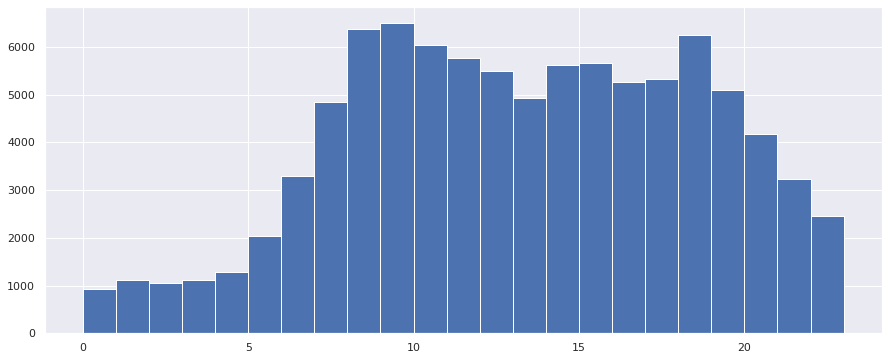

In [16]:
early_teks_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

<AxesSubplot:>

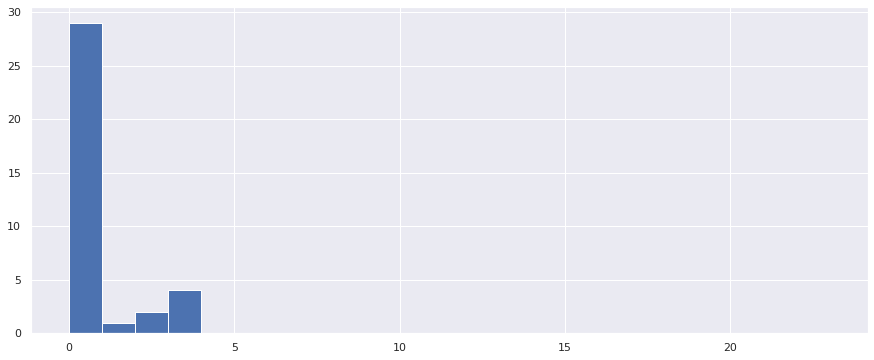

In [17]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [18]:
multi_backend_exposure_keys_df = multi_backend_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_backend_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2021-03-16,ES,8fa2ebff-8211-07db-26e9-6631bdc8b1f9
1,2021-03-12,ES,d213b953-1d9e-1c2d-c63b-561c4a414364
2,2021-03-13,ES,e7b977cc-ff78-c1c1-d928-46106f03eebb
3,2021-03-11,ES,4bc54175-0fa6-ff35-e080-ce1024f6c124
4,2021-03-08,ES,cafa908a-cccf-3775-204f-f06ce78b62fa


In [19]:
active_regions = \
    multi_backend_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['PT', 'MT', 'ES', 'EE', 'IT@ES', 'CH', 'DE@ES', 'DE', 'EU@ES-PRE', 'EU@ES']

In [20]:
multi_backend_summary_df = multi_backend_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_backend_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_backend_summary_df.rename_axis("sample_date", inplace=True)
multi_backend_summary_df = multi_backend_summary_df.fillna(0).astype(int)
multi_backend_summary_df = multi_backend_summary_df.head(backend_generation_days)
multi_backend_summary_df.head()

shared_teks_by_generation_date                                \
region                                  CH     DE DE@ES   EE   ES  EU@ES   
sample_date                                                                
2021-03-20                               0      0    12    0    2     14   
2021-03-19                             140   2881  3068   38  125   3567   
2021-03-18                             303   6582  5128  105  205   7082   
2021-03-17                             444   9275  6979  174  236  10099   
2021-03-16                             587  11824  8712  245  260  13065   

                                     
region      EU@ES-PRE IT@ES   MT PT  
sample_date                          
2021-03-20          8     0    0  0  
2021-03-19        295     0  100  1  
2021-03-18        996    79  102  1  
2021-03-17       1779   153  102  2  
2021-03-16       9792   285  105  1

In [21]:
def compute_keys_cross_sharing(x):
    teks_x = x.key_data_x.item()
    common_teks = set(teks_x).intersection(x.key_data_y.item())
    common_teks_fraction = len(common_teks) / len(teks_x)
    return pd.Series(dict(
        common_teks=common_teks,
        common_teks_fraction=common_teks_fraction,
    ))

multi_backend_exposure_keys_by_region_df = \
    multi_backend_exposure_keys_df.groupby("region").key_data.unique().reset_index()
multi_backend_exposure_keys_by_region_df["_merge"] = True
multi_backend_exposure_keys_by_region_combination_df = \
    multi_backend_exposure_keys_by_region_df.merge(
        multi_backend_exposure_keys_by_region_df, on="_merge")
multi_backend_exposure_keys_by_region_combination_df.drop(
    columns=["_merge"], inplace=True)
if multi_backend_exposure_keys_by_region_combination_df.region_x.nunique() > 1:
    multi_backend_exposure_keys_by_region_combination_df = \
        multi_backend_exposure_keys_by_region_combination_df[
            multi_backend_exposure_keys_by_region_combination_df.region_x !=
            multi_backend_exposure_keys_by_region_combination_df.region_y]
multi_backend_exposure_keys_cross_sharing_df = \
    multi_backend_exposure_keys_by_region_combination_df \
        .groupby(["region_x", "region_y"]) \
        .apply(compute_keys_cross_sharing) \
        .reset_index()
multi_backend_cross_sharing_summary_df = \
    multi_backend_exposure_keys_cross_sharing_df.pivot_table(
        values=["common_teks_fraction"],
        columns="region_x",
        index="region_y",
        aggfunc=lambda x: x.item())
multi_backend_cross_sharing_summary_df

<ipython-input-21-4e21708c19d8>:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  teks_x = x.key_data_x.item()
<ipython-input-21-4e21708c19d8>:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  common_teks = set(teks_x).intersection(x.key_data_y.item())


<ipython-input-21-4e21708c19d8>:33: FutureWarning: `item` has been deprecated and will be removed in a future version
  aggfunc=lambda x: x.item())


common_teks_fraction                                               \
region_x                    CH        DE     DE@ES   EE        ES     EU@ES   
region_y                                                                      
CH                         NaN  0.000000  0.000000  0.0  0.000000  0.000000   
DE                         0.0       NaN  0.996053  0.0  0.890961  0.870262   
DE@ES                      0.0  0.703400       NaN  0.0  0.000000  0.653128   
EE                         0.0  0.000000  0.000000  NaN  0.000000  0.000000   
ES                         0.0  0.017806  0.000000  0.0       NaN  0.018484   
EU@ES                      0.0  0.940961  1.000000  0.0  1.000000       NaN   
EU@ES-PRE                  0.0  0.000017  0.000000  0.0  0.000000  0.000016   
IT@ES                      0.0  0.000034  0.000000  0.0  0.000000  0.026159   
MT                         0.0  0.000000  0.000000  0.0  0.000000  0.000000   
PT                         0.0  0.000000  0.000000  0.0  0.000000  0.000000   

                                         
region_x  EU@ES-PRE     IT@ES   MT   PT  
region_y                                 
CH         0.000000  0.000000  0.0  0.0  
DE         0.000017  0.001217  0.0  0.0  
DE@ES      0.000000  0.000000  0.0  0.0  
EE         0.000000  0.000000  0.0  0.0  
ES         0.000000  0.000000  0.0  0.0  
EU@ES      0.000017  1.000000  0.0  0.0  
EU@ES-PRE       NaN  0.000000  0.0  0.0  
IT@ES      0.000000       NaN  0.0  0.0  
MT         0.000000  0.000000  NaN  0.0  
PT         0.000000  0.000000  0.0  NaN

In [22]:
multi_backend_without_active_region_exposure_keys_df = \
    multi_backend_exposure_keys_df[multi_backend_exposure_keys_df.region != report_backend_identifier]
multi_backend_without_active_region = \
    multi_backend_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_backend_without_active_region

['PT', 'MT', 'EE', 'IT@ES', 'CH', 'DE@ES', 'DE', 'EU@ES-PRE', 'EU@ES']

In [23]:
exposure_keys_summary_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.region == report_backend_identifier]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2021-03-20,2
2021-03-19,125
2021-03-18,205
2021-03-17,236
2021-03-16,260


### Dump API TEKs

In [24]:
tek_list_df = multi_backend_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_base_df = tek_list_df[tek_list_df.region == report_backend_identifier]
tek_list_base_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_base_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_base_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_base_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
4,2021-03-07,ES,"[9b3df5dc-203e-ccf7-bdff-ca998671a39b, 8b58f1d...",2021-03-20,2021-03-20@06
14,2021-03-08,ES,"[cafa908a-cccf-3775-204f-f06ce78b62fa, de25dfb...",2021-03-20,2021-03-20@06
24,2021-03-09,ES,"[7fd7afcf-0dde-bad3-e3da-312c3922a35c, d131dd6...",2021-03-20,2021-03-20@06
34,2021-03-10,ES,"[30740400-eef5-7f1a-905b-e33de991aa62, 7fd3100...",2021-03-20,2021-03-20@06
44,2021-03-11,ES,"[4bc54175-0fa6-ff35-e080-ce1024f6c124, 46d1bd2...",2021-03-20,2021-03-20@06


### Load TEK Dumps

In [25]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    file_paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        file_paths = file_paths[:limit]
    for file_path in file_paths:
        logging.info(f"Loading TEKs from '{file_path}'...")
        iteration_extracted_teks_df = pd.read_json(file_path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [26]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=report_backend_identifier,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date
0,ES,2021-03-07,"[9b3df5dc-203e-ccf7-bdff-ca998671a39b, 8b58f1d...",2021-03-20
1,ES,2021-03-08,"[cafa908a-cccf-3775-204f-f06ce78b62fa, de25dfb...",2021-03-20
2,ES,2021-03-09,"[7fd7afcf-0dde-bad3-e3da-312c3922a35c, d131dd6...",2021-03-20
3,ES,2021-03-10,"[30740400-eef5-7f1a-905b-e33de991aa62, 7fd3100...",2021-03-20
4,ES,2021-03-11,"[4bc54175-0fa6-ff35-e080-ce1024f6c124, 46d1bd2...",2021-03-20


In [27]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2021-03-20,2
2021-03-19,125
2021-03-18,205
2021-03-17,236
2021-03-16,260


### Daily New TEKs

In [28]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-12-26,"{7db5af08-0aee-edde-d73d-bdde1defce37, 753ac72..."
2020-12-27,"{05dbd6a5-30ff-fa56-5932-d766d626b52c, 6ec14b6..."
2020-12-28,"{05dbd6a5-30ff-fa56-5932-d766d626b52c, 6ec14b6..."
2020-12-29,"{05dbd6a5-30ff-fa56-5932-d766d626b52c, 3970974..."
2020-12-30,"{05dbd6a5-30ff-fa56-5932-d766d626b52c, 3970974..."


In [29]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

<ipython-input-29-827222b35590>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
4,2020-12-27,2020-12-18,1114,9
3,2020-12-27,2020-12-17,1056,10
2,2020-12-27,2020-12-16,1024,11
1,2020-12-27,2020-12-15,990,12
0,2020-12-27,2020-12-14,976,13


In [30]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
7,2021-03-20,2021-03-14,1,6
6,2021-03-20,2021-03-13,1,7
5,2021-03-20,2021-03-12,1,8
4,2021-03-20,2021-03-11,1,9
3,2021-03-20,2021-03-10,1,10


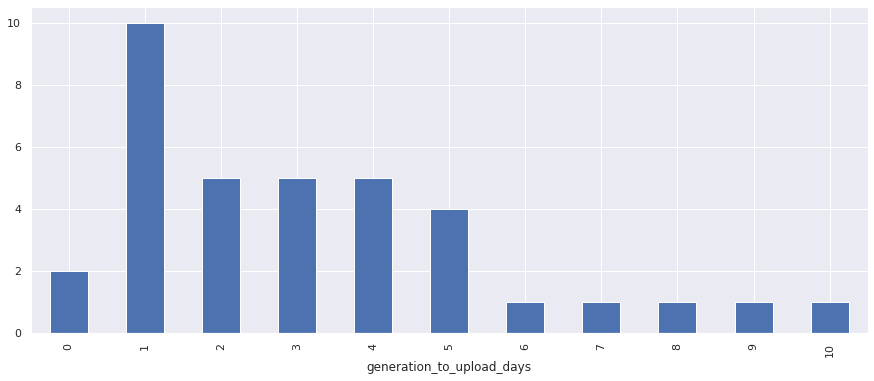

In [31]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [32]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2021-03-20,2,10,5,5,5,4,1,1,1,1,1,0,0,0
2021-03-19,115,78,62,55,42,33,25,14,9,6,2,0,0,0
2021-03-18,122,77,63,58,47,34,26,19,12,10,7,0,0,0
2021-03-17,92,61,50,42,34,26,16,12,7,3,4,0,0,0
2021-03-16,76,49,43,41,34,26,16,11,5,1,1,0,0,0


In [33]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
80,2021-03-16,303.0
81,2021-03-17,347.0
82,2021-03-18,475.0
83,2021-03-19,441.0
84,2021-03-20,36.0


In [34]:
shared_teks_uploaded_on_generation_date_df = shared_teks_generation_to_upload_df[
    shared_teks_generation_to_upload_df.generation_to_upload_days == 0] \
    [["upload_date", "shared_teks"]].rename(
    columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
13,2021-03-20,2
13,2021-03-19,115
13,2021-03-18,122
13,2021-03-17,92
13,2021-03-16,76


In [35]:
estimated_shared_diagnoses_df = shared_teks_generation_to_upload_df \
    .groupby(["upload_date"]).shared_teks.max().reset_index() \
    .sort_values(["upload_date"], ascending=False) \
    .rename(columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_diagnoses",
    })
invalid_shared_diagnoses_dates_mask = \
    estimated_shared_diagnoses_df.sample_date_string.isin(invalid_shared_diagnoses_dates)
estimated_shared_diagnoses_df[invalid_shared_diagnoses_dates_mask] = 0
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
83,2021-03-20,10
82,2021-03-19,115
81,2021-03-18,122
80,2021-03-17,92
79,2021-03-16,76


### Hourly New TEKs

In [36]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=report_backend_identifier, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
0,ES,2021-03-07,"[9b3df5dc-203e-ccf7-bdff-ca998671a39b, 8b58f1d...",2021-03-20,2021-03-20@06
1,ES,2021-03-08,"[cafa908a-cccf-3775-204f-f06ce78b62fa, de25dfb...",2021-03-20,2021-03-20@06
2,ES,2021-03-09,"[7fd7afcf-0dde-bad3-e3da-312c3922a35c, d131dd6...",2021-03-20,2021-03-20@06
3,ES,2021-03-10,"[30740400-eef5-7f1a-905b-e33de991aa62, 7fd3100...",2021-03-20,2021-03-20@06
4,ES,2021-03-11,"[4bc54175-0fa6-ff35-e080-ce1024f6c124, 46d1bd2...",2021-03-20,2021-03-20@06


In [37]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2021-03-19@06,0
1,2021-03-19@07,0
2,2021-03-19@08,7
3,2021-03-19@09,0
4,2021-03-19@10,95


In [38]:
hourly_summary_df = hourly_new_tek_count_df.copy()
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
datetime_utc,,
2021-03-19 07:00:00,2021-03-19@07,0
2021-03-19 08:00:00,2021-03-19@08,7
2021-03-19 09:00:00,2021-03-19@09,0
2021-03-19 10:00:00,2021-03-19@10,95
2021-03-19 11:00:00,2021-03-19@11,0


### Official Statistics

In [39]:
import requests
import pandas.io.json

official_stats_response = requests.get("https://radarcovid.covid19.gob.es/kpi/statistics/basics")
official_stats_response.raise_for_status()
official_stats_df_ = pandas.io.json.json_normalize(official_stats_response.json())

In [40]:
official_stats_df = official_stats_df_.copy()
official_stats_df["date"] = pd.to_datetime(official_stats_df["date"], dayfirst=True)
official_stats_df.head()

,date,applicationsDownloads.totalActualDay,applicationsDownloads.totalAcummulated,communicatedContagions.totalActualDay,communicatedContagions.totalAcummulated
0,2021-03-14,0,7150137,0,53984


In [41]:
official_stats_column_map = {
    "date": "sample_date",
    "applicationsDownloads.totalAcummulated": "app_downloads_es_accumulated",
    "communicatedContagions.totalAcummulated": "shared_diagnoses_es_accumulated",
}
accumulated_suffix = "_accumulated"
accumulated_values_columns = \
    list(filter(lambda x: x.endswith(accumulated_suffix), official_stats_column_map.values()))
interpolated_values_columns = \
    list(map(lambda x: x[:-len(accumulated_suffix)], accumulated_values_columns))

In [42]:
official_stats_df = \
    official_stats_df[official_stats_column_map.keys()] \
        .rename(columns=official_stats_column_map)
official_stats_df["extraction_date"] = extraction_date
official_stats_df.head()

,sample_date,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,extraction_date
0,2021-03-14,7150137,53984,2021-03-20


In [43]:
official_stats_path = "Data/Statistics/Current/RadarCOVID-Statistics.json"
previous_official_stats_df = pd.read_json(official_stats_path, orient="records", lines=True)
previous_official_stats_df["sample_date"] = pd.to_datetime(previous_official_stats_df["sample_date"], dayfirst=True)
official_stats_df = official_stats_df.append(previous_official_stats_df)
official_stats_df.head()

,sample_date,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,extraction_date
0,2021-03-14,7150137,53984,2021-03-20
0,2021-03-14,7150137,53984,2021-03-20
1,2021-03-07,7127140,53250,2021-03-17
2,2021-02-28,7101333,52555,2021-03-11
3,2021-02-21,7074591,51684,2021-03-03


In [44]:
official_stats_df = official_stats_df[~(official_stats_df.shared_diagnoses_es_accumulated == 0)]
official_stats_df.sort_values("extraction_date", ascending=False, inplace=True)
official_stats_df.drop_duplicates(subset=["sample_date"], keep="first", inplace=True)
official_stats_df.head()

,sample_date,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,extraction_date
0,2021-03-14,7150137,53984,2021-03-20
1,2021-03-07,7127140,53250,2021-03-17
2,2021-02-28,7101333,52555,2021-03-11
3,2021-02-21,7074591,51684,2021-03-03
4,2021-02-14,7033536,50503,2021-02-24


In [45]:
official_stats_stored_df = official_stats_df.copy()
official_stats_stored_df["sample_date"] = official_stats_stored_df.sample_date.dt.strftime("%Y-%m-%d")
official_stats_stored_df.to_json(official_stats_path, orient="records", lines=True)

In [46]:
official_stats_df.drop(columns=["extraction_date"], inplace=True)
official_stats_df = confirmed_days_df.merge(official_stats_df, how="left")
official_stats_df.sort_values("sample_date", ascending=False, inplace=True)
official_stats_df.head()

,sample_date,sample_date_string,app_downloads_es_accumulated,shared_diagnoses_es_accumulated
422,2021-03-20,2021-03-20,NaN,NaN
421,2021-03-19,2021-03-19,NaN,NaN
420,2021-03-18,2021-03-18,NaN,NaN
419,2021-03-17,2021-03-17,NaN,NaN
418,2021-03-16,2021-03-16,NaN,NaN


In [47]:
official_stats_df[accumulated_values_columns] = \
    official_stats_df[accumulated_values_columns] \
        .astype(float).interpolate(limit_area="inside")
official_stats_df[interpolated_values_columns] = \
    official_stats_df[accumulated_values_columns].diff(periods=-1)
official_stats_df.drop(columns="sample_date", inplace=True)
official_stats_df.head()

,sample_date_string,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
422,2021-03-20,NaN,NaN,NaN,NaN
421,2021-03-19,NaN,NaN,NaN,NaN
420,2021-03-18,NaN,NaN,NaN,NaN
419,2021-03-17,NaN,NaN,NaN,NaN
418,2021-03-16,NaN,NaN,NaN,NaN


### Data Merge

In [48]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2021-03-20,2,36.0
1,2021-03-19,125,441.0
2,2021-03-18,205,475.0
3,2021-03-17,236,347.0
4,2021-03-16,260,303.0


In [49]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2021-03-20,2,36.0,2.0
1,2021-03-19,125,441.0,115.0
2,2021-03-18,205,475.0,122.0
3,2021-03-17,236,347.0,92.0
4,2021-03-16,260,303.0,76.0


In [50]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2021-03-20,2,36.0,2.0,10.0
1,2021-03-19,125,441.0,115.0,115.0
2,2021-03-18,205,475.0,122.0,122.0
3,2021-03-17,236,347.0,92.0,92.0
4,2021-03-16,260,303.0,76.0,76.0


In [51]:
result_summary_df = result_summary_df.merge(
    official_stats_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
0,2021-03-20,2.0,36.0,2.0,10.0,NaN,NaN,NaN,NaN
1,2021-03-19,125.0,441.0,115.0,115.0,NaN,NaN,NaN,NaN
2,2021-03-18,205.0,475.0,122.0,122.0,NaN,NaN,NaN,NaN
3,2021-03-17,236.0,347.0,92.0,92.0,NaN,NaN,NaN,NaN
4,2021-03-16,260.0,303.0,76.0,76.0,NaN,NaN,NaN,NaN


In [52]:
result_summary_df = confirmed_eu_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
0,2020-12-27,38332.0,66512.0,22987.0,21406.0,495.0,3049.0,6176058.0,26729.0,43800.857143,210.857143
1,2020-12-28,61787.0,64899.0,21271.0,27432.0,782.0,3411.0,6210067.0,27026.0,34009.000000,297.000000
2,2020-12-29,66354.0,62477.0,21388.0,48380.0,1983.0,5726.0,6244076.0,27323.0,34009.000000,297.000000
3,2020-12-30,111998.0,65474.0,22105.0,55776.0,2402.0,7061.0,6278085.0,27620.0,34009.000000,297.000000
4,2020-12-31,92273.0,65917.0,22882.0,48686.0,2069.0,6483.0,6312094.0,27917.0,34009.000000,297.000000


In [53]:
result_summary_df = confirmed_es_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases_es,covid_cases_es,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
0,2020-12-27,12662.0,8245.0,38332.0,66512.0,22987.0,21406.0,495.0,3049.0,6176058.0,26729.0,43800.857143,210.857143
1,2020-12-28,24462.0,8595.0,61787.0,64899.0,21271.0,27432.0,782.0,3411.0,6210067.0,27026.0,34009.000000,297.000000
2,2020-12-29,14089.0,9086.0,66354.0,62477.0,21388.0,48380.0,1983.0,5726.0,6244076.0,27323.0,34009.000000,297.000000
3,2020-12-30,16716.0,9704.0,111998.0,65474.0,22105.0,55776.0,2402.0,7061.0,6278085.0,27620.0,34009.000000,297.000000
4,2020-12-31,18047.0,10473.0,92273.0,65917.0,22882.0,48686.0,2069.0,6483.0,6312094.0,27917.0,34009.000000,297.000000


In [54]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df = result_summary_df.merge(source_regions_for_summary_df, how="left")
result_summary_df.set_index(["sample_date", "source_regions"], inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,,new_cases_es,covid_cases_es,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es
sample_date,source_regions,,,,,,,,,,,,
2021-03-20,ES,6216.0,3108.0,6216.0,3108.0,2.0,36.0,2.0,10.0,NaN,NaN,NaN,NaN
2021-03-19,ES,6216.0,4090.0,6216.0,4090.0,125.0,441.0,115.0,115.0,NaN,NaN,NaN,NaN
2021-03-18,ES,6216.0,4854.0,6216.0,4854.0,205.0,475.0,122.0,122.0,NaN,NaN,NaN,NaN
2021-03-17,ES,6092.0,4859.0,6092.0,4859.0,236.0,347.0,92.0,92.0,NaN,NaN,NaN,NaN
2021-03-16,ES,4962.0,5006.0,4962.0,5006.0,260.0,303.0,76.0,76.0,NaN,NaN,NaN,NaN


In [55]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case_es"] = \
        (result_summary_df.shared_diagnoses_es / result_summary_df.covid_cases_es).fillna(0)

result_summary_df.head(daily_plot_days)

,,new_cases_es,covid_cases_es,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,app_downloads_es_accumulated,shared_diagnoses_es_accumulated,app_downloads_es,shared_diagnoses_es,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case,shared_diagnoses_per_covid_case_es
sample_date,source_regions,,,,,,,,,,,,,,,
2021-03-20,ES,6216,3108,6216,3108,2,36,2,10,0,0,0,0,3.600000,0.003218,0.000000
2021-03-19,ES,6216,4090,6216,4090,125,441,115,115,0,0,0,0,3.834783,0.028117,0.000000
2021-03-18,ES,6216,4854,6216,4854,205,475,122,122,0,0,0,0,3.893443,0.025134,0.000000
2021-03-17,ES,6092,4859,6092,4859,236,347,92,92,0,0,0,0,3.771739,0.018934,0.000000
2021-03-16,ES,4962,5006,4962,5006,260,303,76,76,0,0,0,0,3.986842,0.015182,0.000000
2021-03-15,ES,11358,4870,11358,4870,272,305,69,69,0,0,0,0,4.420290,0.014168,0.000000
2021-03-14,ES,5348,4956,5348,4956,293,304,69,69,7150137,53984,3285,104,4.405797,0.013923,0.020985
2021-03-13,ES,5348,4956,5348,4956,313,302,84,84,7146851,53879,3285,104,3.595238,0.016949,0.020985
2021-03-12,ES,5348,4956,5348,4956,342,368,101,101,7143566,53774,3285,104,3.643564,0.020379,0.020985


In [56]:
def compute_aggregated_results_summary(days) -> pd.DataFrame:
    aggregated_result_summary_df = result_summary_df.copy()
    aggregated_result_summary_df["covid_cases_for_ratio"] = \
        aggregated_result_summary_df.covid_cases.mask(
            aggregated_result_summary_df.shared_diagnoses == 0, 0)
    aggregated_result_summary_df["covid_cases_for_ratio_es"] = \
        aggregated_result_summary_df.covid_cases_es.mask(
            aggregated_result_summary_df.shared_diagnoses_es == 0, 0)
    aggregated_result_summary_df = aggregated_result_summary_df \
        .sort_index(ascending=True).fillna(0).rolling(days).agg({
        "covid_cases": "sum",
        "covid_cases_es": "sum",
        "covid_cases_for_ratio": "sum",
        "covid_cases_for_ratio_es": "sum",
        "shared_teks_by_generation_date": "sum",
        "shared_teks_by_upload_date": "sum",
        "shared_diagnoses": "sum",
        "shared_diagnoses_es": "sum",
    }).sort_index(ascending=False)

    with pd.option_context("mode.use_inf_as_na", True):
        aggregated_result_summary_df = aggregated_result_summary_df.fillna(0).astype(int)
        aggregated_result_summary_df["teks_per_shared_diagnosis"] = \
            (aggregated_result_summary_df.shared_teks_by_upload_date /
             aggregated_result_summary_df.covid_cases_for_ratio).fillna(0)
        aggregated_result_summary_df["shared_diagnoses_per_covid_case"] = \
            (aggregated_result_summary_df.shared_diagnoses /
             aggregated_result_summary_df.covid_cases_for_ratio).fillna(0)
        aggregated_result_summary_df["shared_diagnoses_per_covid_case_es"] = \
            (aggregated_result_summary_df.shared_diagnoses_es /
             aggregated_result_summary_df.covid_cases_for_ratio_es).fillna(0)

    return aggregated_result_summary_df

In [57]:
aggregated_result_with_7_days_window_summary_df = compute_aggregated_results_summary(days=7)
aggregated_result_with_7_days_window_summary_df.head()

,,covid_cases,covid_cases_es,covid_cases_for_ratio,covid_cases_for_ratio_es,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,shared_diagnoses_es,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case,shared_diagnoses_per_covid_case_es
sample_date,source_regions,,,,,,,,,,,
2021-03-20,ES,31743,31743,31743,4956,1393,2211,553,104,0.069653,0.017421,0.020985
2021-03-19,ES,33591,33591,33591,9912,1704,2477,627,208,0.073740,0.018666,0.020985
2021-03-18,ES,34457,34457,34457,14868,1921,2404,613,312,0.069768,0.017790,0.020985
2021-03-17,ES,34746,34746,34746,20011,2088,2444,613,416,0.070339,0.017642,0.020789
2021-03-16,ES,34998,34998,34998,25122,2249,2507,630,520,0.071633,0.018001,0.020699


In [58]:
last_7_days_summary = aggregated_result_with_7_days_window_summary_df.to_dict(orient="records")[1]
last_7_days_summary

{'covid_cases': 33591,
 'covid_cases_es': 33591,
 'covid_cases_for_ratio': 33591,
 'covid_cases_for_ratio_es': 9912,
 'shared_teks_by_generation_date': 1704,
 'shared_teks_by_upload_date': 2477,
 'shared_diagnoses': 627,
 'shared_diagnoses_es': 208,
 'teks_per_shared_diagnosis': 0.0737399898782412,
 'shared_diagnoses_per_covid_case': 0.018665714030543897,
 'shared_diagnoses_per_covid_case_es': 0.020984665052461663}

In [59]:
aggregated_result_with_14_days_window_summary_df = compute_aggregated_results_summary(days=13)
last_14_days_summary = aggregated_result_with_14_days_window_summary_df.to_dict(orient="records")[1]
last_14_days_summary

{'covid_cases': 63142,
 'covid_cases_es': 63142,
 'covid_cases_for_ratio': 63142,
 'covid_cases_for_ratio_es': 39463,
 'shared_teks_by_generation_date': 3483,
 'shared_teks_by_upload_date': 4725,
 'shared_diagnoses': 1182,
 'shared_diagnoses_es': 827,
 'teks_per_shared_diagnosis': 0.07483133255202559,
 'shared_diagnoses_per_covid_case': 0.01871971112730037,
 'shared_diagnoses_per_covid_case_es': 0.020956338849048475}

## Report Results

In [60]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "source_regions": "Source Countries",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend",
    "region_x": "Backend\u00A0(A)",
    "region_y": "Backend\u00A0(B)",
    "common_teks": "Common TEKs Shared Between Backends",
    "common_teks_fraction": "Fraction of TEKs in Backend (A) Available in Backend (B)",
    "covid_cases": "COVID-19 Cases (Source Countries)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date (Source Countries)",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date (Source Countries)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date (Source Countries)",
    "shared_diagnoses": "Shared Diagnoses (Source Countries – Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis (Source Countries)",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Source Countries)",

    "covid_cases_es": "COVID-19 Cases (Spain)",
    "app_downloads_es": "App Downloads (Spain – Official)",
    "shared_diagnoses_es": "Shared Diagnoses (Spain – Official)",
    "shared_diagnoses_per_covid_case_es": "Usage Ratio (Spain)",
}

In [61]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",

    "covid_cases_es",
    "app_downloads_es",
    "shared_diagnoses_es",
    "shared_diagnoses_per_covid_case_es",
]

summary_percentage_columns= [
    "shared_diagnoses_per_covid_case_es",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [62]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,,COVID-19 Cases (Source Countries),Shared TEKs by Generation Date (Source Countries),Shared TEKs by Upload Date (Source Countries),Shared TEKs Uploaded on Generation Date (Source Countries),Shared Diagnoses (Source Countries – Estimation),TEKs Uploaded per Shared Diagnosis (Source Countries),Usage Ratio (Source Countries),COVID-19 Cases (Spain),App Downloads (Spain – Official),Shared Diagnoses (Spain – Official),Usage Ratio (Spain)
Sample Date (UTC),Source Countries,,,,,,,,,,,
2021-03-20,ES,3108,2,36,2,10,3.600000,0.003218,3108,0,0,0.000000
2021-03-19,ES,4090,125,441,115,115,3.834783,0.028117,4090,0,0,0.000000
2021-03-18,ES,4854,205,475,122,122,3.893443,0.025134,4854,0,0,0.000000
2021-03-17,ES,4859,236,347,92,92,3.771739,0.018934,4859,0,0,0.000000
2021-03-16,ES,5006,260,303,76,76,3.986842,0.015182,5006,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31,"ES,DE,DK,HR,IE,IT,LV,NL,PL",65917,22882,48686,2069,6483,7.509795,0.098351,10473,34009,297,0.028359
2020-12-30,"ES,DE,DK,HR,IE,IT,LV,NL,PL",65474,22105,55776,2402,7061,7.899164,0.107844,9704,34009,297,0.030606
2020-12-29,"ES,DE,DK,HR,IE,IT,LV,NL,PL",62477,21388,48380,1983,5726,8.449179,0.091650,9086,34009,297,0.032688


### Daily Summary Plots

/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/hostedtoolcache/Python/3.8.8/x64/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNu

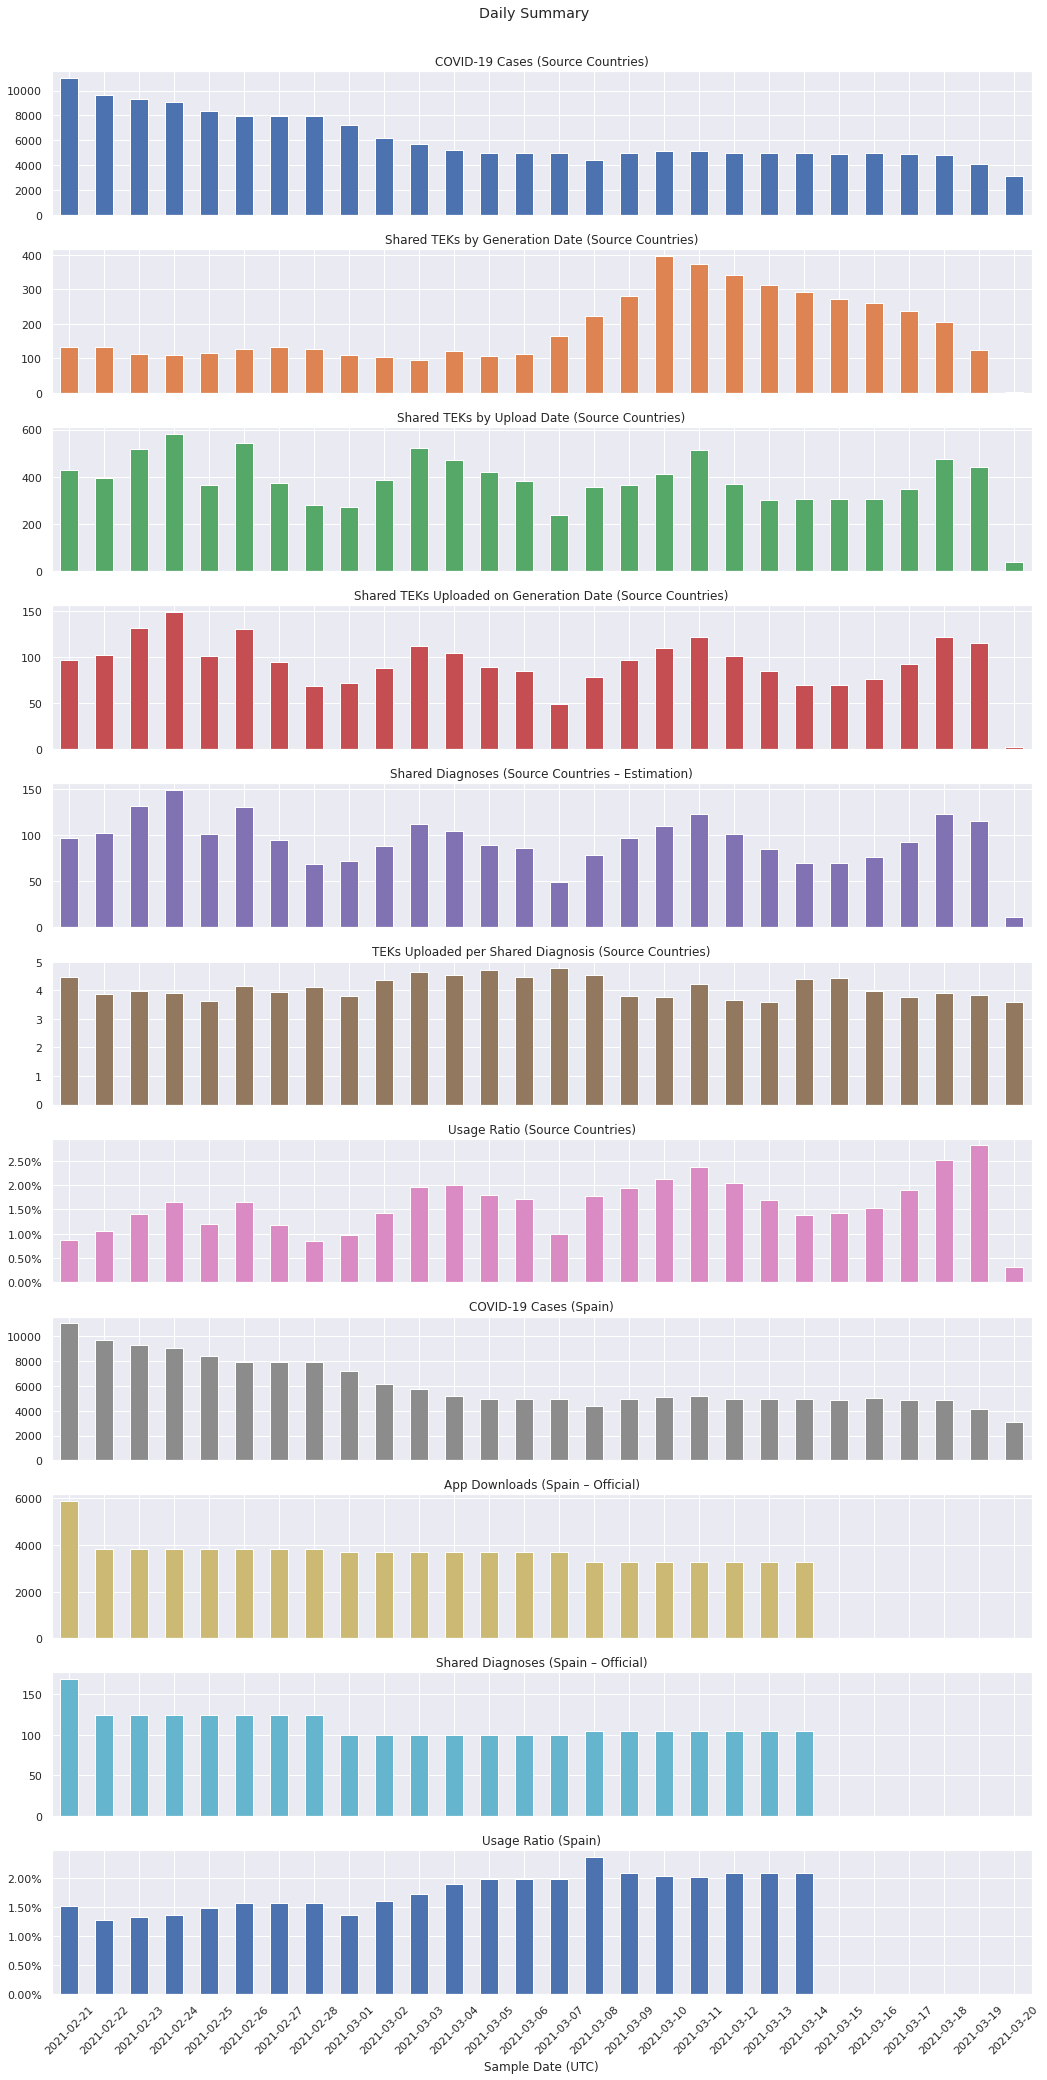

In [63]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .droplevel(level=["source_regions"]) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 30), legend=False)
ax_ = summary_ax_list[0]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

for percentage_column in summary_percentage_columns:
    percentage_column_index = summary_columns.index(percentage_column)
    summary_ax_list[percentage_column_index].yaxis \
        .set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

### Daily Generation to Upload Period Table

In [64]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2021-03-20,2,10,5,5,5,4,1,1,1,1,1,0,0,0
2021-03-19,115,78,62,55,42,33,25,14,9,6,2,0,0,0
2021-03-18,122,77,63,58,47,34,26,19,12,10,7,0,0,0
2021-03-17,92,61,50,42,34,26,16,12,7,3,4,0,0,0
2021-03-16,76,49,43,41,34,26,16,11,5,1,1,0,0,0
2021-03-15,69,58,46,42,33,22,14,8,6,4,2,1,0,0
2021-03-14,69,48,41,37,33,25,16,12,9,7,7,0,0,0
2021-03-13,84,57,40,36,29,23,14,8,5,3,3,0,0,0
2021-03-12,101,69,58,46,32,24,13,9,8,5,3,0,0,0


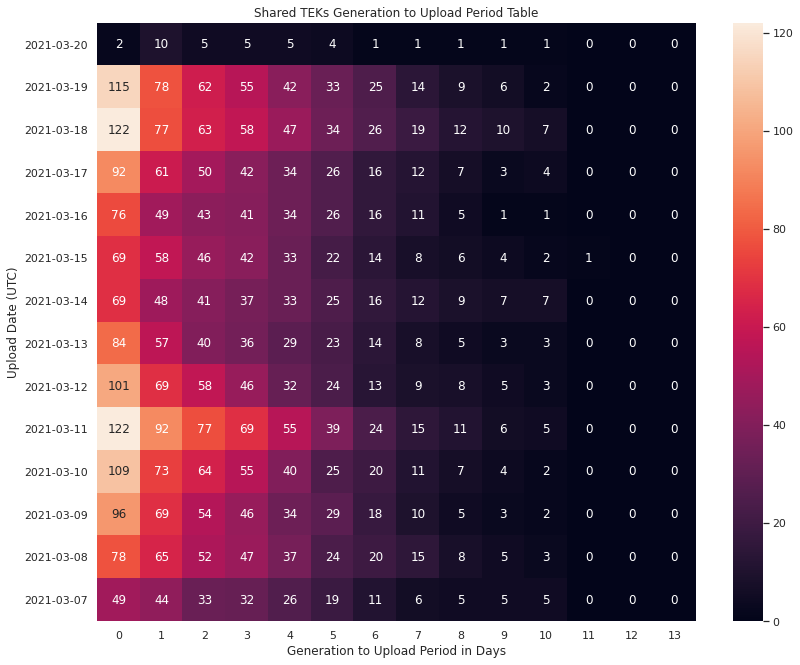

In [65]:
fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(12, 1 + 0.6 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

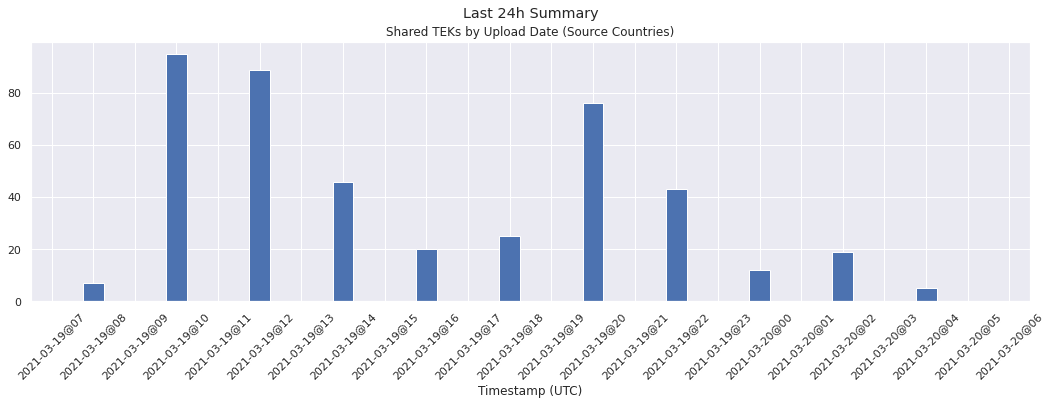

In [66]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [67]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}" if x != 0 else "",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}" if x != 0 else "",
    display_column_name_mapping["shared_diagnoses_per_covid_case_es"]: lambda x: f"{x:.2%}" if x != 0 else "",
}
general_columns = \
    list(filter(lambda x: x not in display_formatters, display_column_name_mapping.values()))
general_formatter = lambda x: f"{x}" if x != 0 else ""
display_formatters.update(dict(map(lambda x: (x, general_formatter), general_columns)))

daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_backend_summary_table_html = multi_backend_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

def format_multi_backend_cross_sharing_fraction(x):
    if pd.isna(x):
        return "-"
    elif round(x * 100, 1) == 0:
        return ""
    else:
        return f"{x:.1%}"

multi_backend_cross_sharing_summary_table_html = multi_backend_cross_sharing_summary_df \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(
        classes="table-center",
        formatters=display_formatters,
        float_format=format_multi_backend_cross_sharing_fraction)
multi_backend_cross_sharing_summary_table_html = \
    multi_backend_cross_sharing_summary_table_html \
        .replace("<tr>","<tr style=\"text-align: center;\">")

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index.get_level_values("sample_date") == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.item()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.item()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.item()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.item()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.item()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.item()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)

display_source_regions = ", ".join(report_source_regions)
if len(report_source_regions) == 1:
    display_brief_source_regions = report_source_regions[0]
else:
    display_brief_source_regions = f"{len(report_source_regions)} 🇪🇺"

<ipython-input-67-0a0cb8e530af>:55: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.covid_cases.item()
<ipython-input-67-0a0cb8e530af>:57: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_teks_by_generation_date.item()
<ipython-input-67-0a0cb8e530af>:59: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_teks_by_upload_date.item()
<ipython-input-67-0a0cb8e530af>:61: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_diagnoses.item()
<ipython-input-67-0a0cb8e530af>:63: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.teks_per_shared_diagnosis.item()
<ipython-input-67-0a0cb8e530af>:65: FutureWarning: `item` has been deprecated and 

In [68]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    df = df.copy()
    df_styler = df.style.format(display_formatters)
    media_path = get_temporary_image_path()
    dfi.export(df_styler, media_path)
    return media_path

In [69]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_backend_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_backend_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

### Save Results

In [70]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_backend_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Summary-Table.csv")
multi_backend_cross_sharing_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Cross-Sharing-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_backend_summary_table_image_path,
    report_resources_path_prefix + "Multi-Backend-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [71]:
def generate_summary_api_results(df: pd.DataFrame) -> list:
    api_df = df.reset_index().copy()
    api_df["sample_date_string"] = \
        api_df["sample_date"].dt.strftime("%Y-%m-%d")
    api_df["source_regions"] = \
        api_df["source_regions"].apply(lambda x: x.split(","))
    return api_df.to_dict(orient="records")

summary_api_results = \
    generate_summary_api_results(df=result_summary_df)
today_summary_api_results = \
    generate_summary_api_results(df=extraction_date_result_summary_df)[0]

summary_results = dict(
    backend_identifier=report_backend_identifier,
    source_regions=report_source_regions,
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=0,
    ),
    today=today_summary_api_results,
    last_7_days=last_7_days_summary,
    last_14_days=last_14_days_summary,
    daily_results=summary_api_results)

summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [72]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_backend_summary_table_html=multi_backend_summary_table_html,
    multi_backend_cross_sharing_summary_table_html=multi_backend_cross_sharing_summary_table_html,
    display_source_regions=display_source_regions)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [73]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule" and \
        (shared_teks_by_upload_date_last_hour or not are_today_results_partial):
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    if are_today_results_partial:
        today_addendum = " (Partial)"
    else:
        today_addendum = ""

    def format_shared_diagnoses_per_covid_case(value) -> str:
        if value == 0:
            return "–"
        return f"≤{value:.2%}"

    display_shared_diagnoses_per_covid_case = \
        format_shared_diagnoses_per_covid_case(value=shared_diagnoses_per_covid_case)
    display_last_14_days_shared_diagnoses_per_covid_case = \
        format_shared_diagnoses_per_covid_case(value=last_14_days_summary["shared_diagnoses_per_covid_case"])
    display_last_14_days_shared_diagnoses_per_covid_case_es = \
        format_shared_diagnoses_per_covid_case(value=last_14_days_summary["shared_diagnoses_per_covid_case_es"])

    status = textwrap.dedent(f"""
        #RadarCOVID – {extraction_date_with_hour}

        Today{today_addendum}:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f}
        - Usage Ratio: {display_shared_diagnoses_per_covid_case}

        Last 14 Days:
        - Usage Ratio (Estimation): {display_last_14_days_shared_diagnoses_per_covid_case}
        - Usage Ratio (Official): {display_last_14_days_shared_diagnoses_per_covid_case_es}

        Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)